# Notebook for the analysis of XPS data 

Analysis of `dati/Mg_Ag_30V_3d.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


/Users/a129544/anaconda3/envs/XPS/lib/python3.8/site-packages/arpes/config.py:54: UserWarning: Could not find local configuration file. If you don't have one, you can safely ignore this message.
  warnings.warn(msg)


Activating auto-logging. Current session state plus future input saved.
Filename       : logs/unnamed_2023-06-10_17-08-42.log
Mode           : backup
Output logging : False
Raw input log  : False
Timestamping   : False
State          : active


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Mg_Ag_30V_3d.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,920.0,916.87,8513,1141,1275,1269,1213,1150,1233,1232
1,919.7,916.58,8432,1155,1266,1177,1254,1233,1232,1115
2,919.4,916.30,8266,1244,1199,1247,1185,1102,1143,1146
3,919.1,915.97,8450,1175,1260,1219,1271,1191,1147,1187
4,918.8,915.69,8278,1152,1186,1222,1213,1128,1168,1209
...,...,...,...,...,...,...,...,...,...,...
263,841.2,839.08,10244,1420,1487,1505,1393,1469,1468,1502
264,840.9,838.81,10026,1418,1483,1361,1471,1439,1455,1399
265,840.6,838.50,10214,1519,1445,1480,1398,1406,1508,1458
266,840.3,838.23,10067,1402,1421,1463,1455,1416,1456,1454


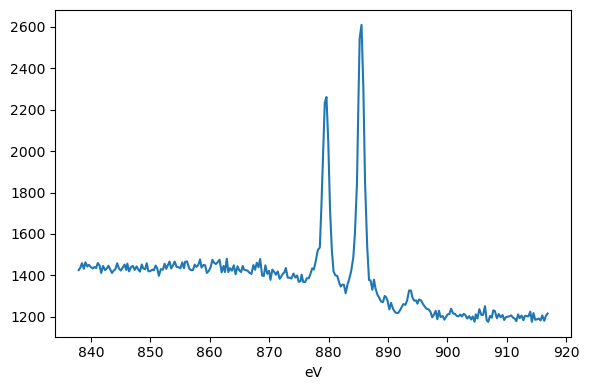

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_15359/172844745.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(873, 888, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,1395.710,0.000,inf,61.460,True,,
a_center,879.531,875.000,880.000,0.031,True,,
a_fwhm,1.425,-inf,inf,0.073,False,2.3548200*a_sigma,
a_height,919.913,-inf,inf,40.744,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,0.605,0.000,inf,0.031,True,,
b_amplitude,1803.029,0.000,inf,59.362,True,,
b_center,885.458,880.000,890.000,0.021,True,,
b_fwhm,1.306,-inf,inf,0.052,False,2.3548200*b_sigma,
b_height,1296.925,-inf,inf,42.470,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,0.555,0.000,inf,0.022,True,,


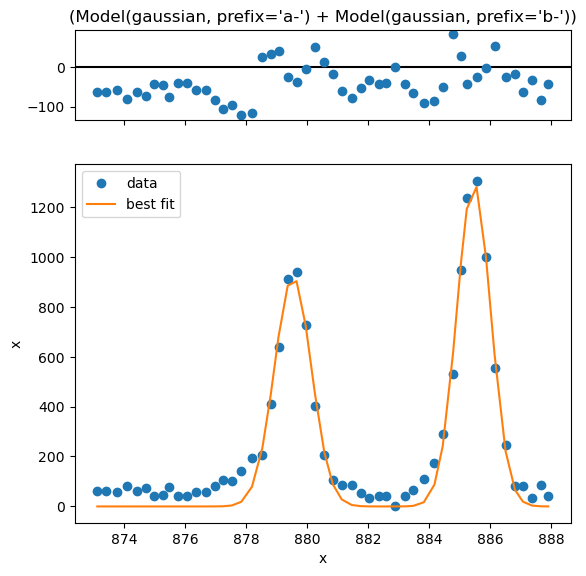

In [7]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(873, 888, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)
test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 878, "max":880, "min":875 },
        "a_amplitude": {"min": 0},
        "b_center": {"value": 885, "max":890, "min":880},
        "b_amplitude": {"min": 0},
    }
)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_15359/1147291249.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(873, 888, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,1174.274,0.000,inf,38.211,True,,
a_center,879.534,875.000,880.000,0.015,True,,
a_fwhm,1.251,-inf,inf,0.040,False,2.3548200*a_sigma,
a_height,882.103,-inf,inf,23.008,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,0.531,0.000,inf,0.017,True,,
b_amplitude,1621.654,0.000,inf,38.786,True,,
b_center,885.460,880.000,890.000,0.010,True,,
b_fwhm,1.205,-inf,inf,0.029,False,2.3548200*b_sigma,
b_height,1264.062,-inf,inf,23.537,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,0.512,0.000,inf,0.012,True,,


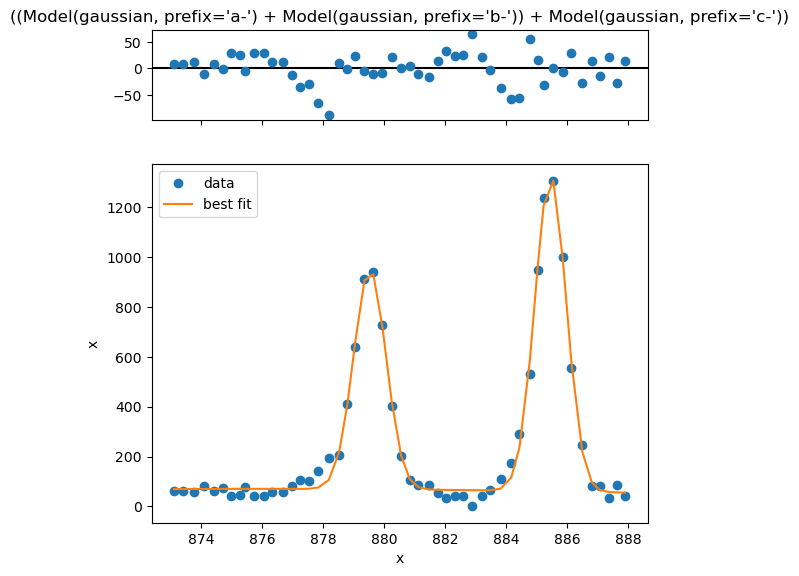

In [8]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)

selection = df['Energy(meas)'].between(873, 888, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + GaussianModel(prefix="c_") #+ GaussianModel(prefix="d_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 878, "max":880, "min":875 },
        "a_amplitude": {"min": 0},
        "b_center": {"value": 885, "max":890, "min":880},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 875, "max": 876, "min":873},
        "c_amplitude": {"min": 0},
        "c_sigma":{"max": 30, "min": 1},
    }

)
result.plot()
result

In [9]:
print(result.fit_report())

[[Model]]
    ((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(gaussian, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 940
    # data points      = 51
    # variables        = 9
    chi-square         = 43279.3876
    reduced chi-square = 1030.46161
    Akaike info crit   = 361.923913
    Bayesian info crit = 379.310343
    R-squared          = 0.99252893
[[Variables]]
    a_amplitude:  1174.27393 +/- 38.2112982 (3.25%) (init = 0)
    a_center:     879.533751 +/- 0.01521467 (0.00%) (init = 878)
    a_sigma:      0.53108020 +/- 0.01683833 (3.17%) (init = 3.25)
    b_amplitude:  1621.65403 +/- 38.7859668 (2.39%) (init = 0)
    b_center:     885.460246 +/- 0.01036633 (0.00%) (init = 885)
    b_sigma:      0.51179940 +/- 0.01231761 (2.41%) (init = 3.25)
    c_amplitude:  3029.62704 +/- 4340.25748 (143.26%) (init = 0)
    c_center:     876.000000 +/- 21.3097680 (2.43%) (init = 875)
    c_sigma:      17.1484977 +/- 24.8484742